In [9]:
import datetime
import math
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# current date 2020.06.15

dtFormat = "%Y-%m-%dT%H:%M:%S"
sunSetAt = datetime.datetime.strptime("2020-06-15T21:19:00", dtFormat)
sunRiseAt = datetime.datetime.strptime("2020-06-15T21:19:00", dtFormat)
astroTwiStartAt = datetime.datetime.strptime("2020-06-15T23:30:00", dtFormat)
astroTwiEndAt = datetime.datetime.strptime("2020-06-16T02:30:00", dtFormat)

noonAt = datetime.datetime.strptime("2020-06-16T12:00:00", dtFormat)


# https://en.wikipedia.org/wiki/Sigmoid_function
def sigmoid(x):
    return 1 / (1 + math.pow(math.e, (x * -1)))


# https://en.wikipedia.org/wiki/Generalised_logistic_function
def gen_logistic_curve(t):
    a = 0
    b = 0.7
    k = 1.0
    q = 0.5
    v = 0.5
    m = 0
    c = 1
    return a + ((k - a) / (math.pow(c + q * (math.pow(math.e, (b * t) * -1)), (1 / v))))


def timedelta_to_range(t1, t2, now):
    curve_zone_start = -6
    curve_zone_end = 6
    polate = interp1d([t1, t2], [curve_zone_start, curve_zone_end])
    return polate(now)


def brightness_to_settings(brightness):
    min_shutter_speed = 15
    max_shutter_speed = 1/8000
    min_iso = 1600
    max_iso = 100
    aperture = 2.8
    shutter_polate = interp1d([0, 1], [min_shutter_speed, max_shutter_speed])
    iso_polate = interp1d([0, 1], [min_iso, max_iso])
    return shutter_polate(brightness), iso_polate(brightness)


now = datetime.datetime.strptime("2020-06-15T23:30:00", dtFormat)

np_time = np.array([])
np_brightness = np.array([])
np_shutter_speed = np.array([])
np_iso = np.array([])

for i in range(0, 13):
    t = (now + timedelta(hours=i))
    mapped = timedelta_to_range(astroTwiStartAt.timestamp(), noonAt.timestamp(), t.timestamp())
    brightness = gen_logistic_curve(mapped)
    settings = brightness_to_settings(brightness)
    
    np_time = np.append(np_time, [t.strftime("%Y-%m-%dT%H:%M:%S")])
    np_brightness = np.append(np_brightness, [brightness])
    np_shutter_speed = np.append(np_shutter_speed, [settings[0]])
    np_iso = np.append(np_iso, [settings[1]])

df = pd.DataFrame({
    'brightness': pd.Series(np_brightness, dtype='float64'),
    'shutter_speed': pd.Series(np_shutter_speed, dtype='float64'),
    'iso': pd.Series(np_iso, dtype='float64')
})

cut_labels_iso = [100, 200, 400, 800, 1600]
cut_bins_iso = [100, 150, 300, 600, 1200, 3200]
df['cut_iso'] = pd.cut(df['iso'], bins=cut_bins_iso, labels=cut_labels_iso)

cut_labels_shutter_speed = [1/8000, 1/4000, 1/2000, 1/1000, 1/500, 1/250, 1/125, 1/60, 1/30, 1/15, 1/8, 1/4, 1/2, 1, 2, 4, 8, 15]
cut_bins_shutter_speed = [1/8000, 1/6000, 1/4000, 1/3000, 1/750, 1/375, 1/190, 1/90, 1/45, 1/22, 1/11, 1/6, 1/3, 0.75, 1.5, 3, 6, 11, 15]
df['cut_shutter_speed'] = pd.cut(df['shutter_speed'], bins=cut_bins_shutter_speed, labels=cut_labels_shutter_speed)

df[['cut_shutter_speed', 'shutter_speed']]

,cut_shutter_speed,shutter_speed
0,15.00,14.987282
1,15.00,14.953847
2,15.00,14.840445
3,15.00,14.493302
4,15.00,13.595405
5,15.00,11.779592
6,8.00,9.077683
7,8.00,6.152324
8,4.00,3.741410
9,2.00,2.110825


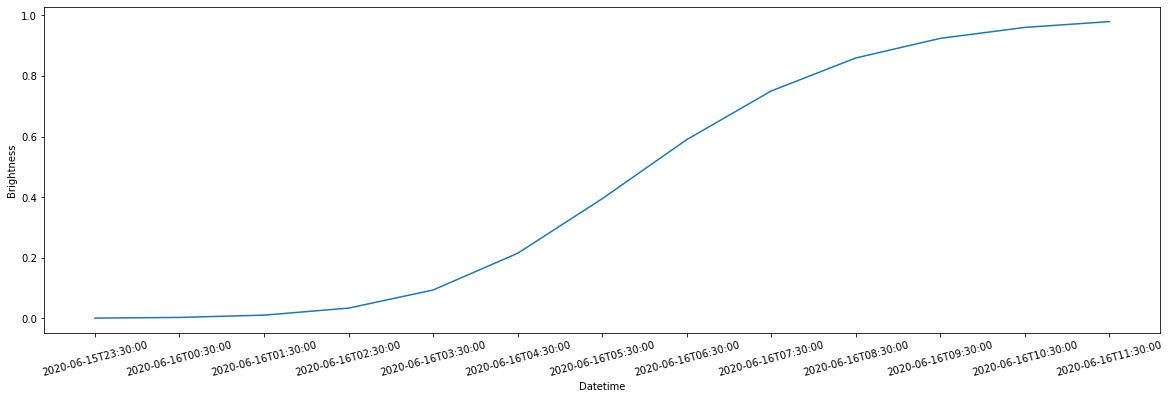

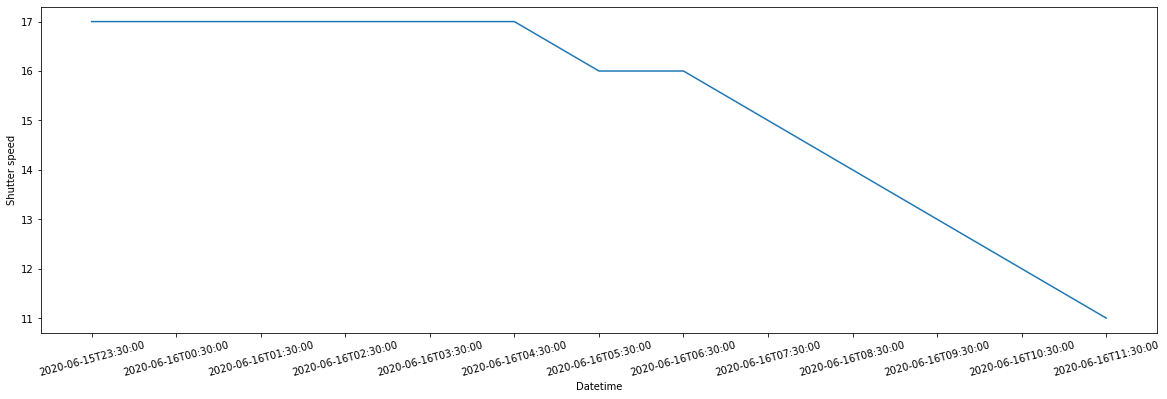

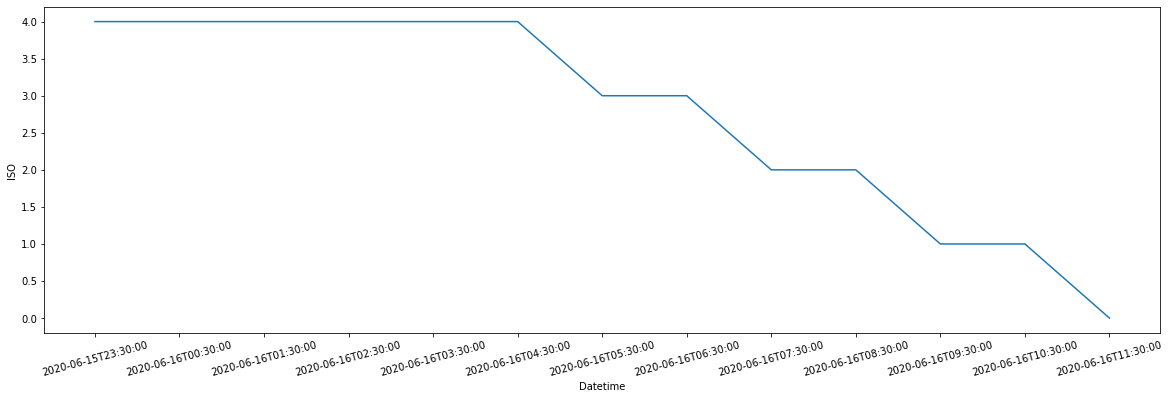

In [10]:
def show_plot(x, y, y_label):
    plt.rcParams["figure.figsize"] = (20,6)
    plt.xticks(rotation=15)
    plt.xlabel("Datetime")
    plt.ylabel(y_label)
    plt.plot(x, y)
    plt.show()

show_plot(np_time, np_brightness, "Brightness")
show_plot(np_time, df['cut_shutter_speed'], "Shutter speed")
show_plot(np_time, df['cut_iso'], "ISO")